In [1]:
# Basic libraries for file handling and visualization
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for downloading files from Google Drive
import gdown

# Libraries for deep learning and image processing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define dataset URL and paths
gdrive_url = "https://drive.google.com/uc?id=1kniWQkolYoYUB9D0arAxHzrn4Z3vh8c_"
dataset_path = './data/deepsea_dataset.zip'
extracted_path = './data/deepsea_dataset'

In [3]:
# Create the data directory if it doesn't exist
os.makedirs('./data', exist_ok=True)

# Download the dataset if not already downloaded
if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    gdown.download(gdrive_url, dataset_path, quiet=False)
    print("Dataset downloaded successfully.")
else:
    print("Dataset already downloaded.")

# Extract the dataset if not already extracted
if not os.path.exists(extracted_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall('./data')
    print("Dataset extracted successfully.")
else:
    print("Dataset already extracted.")

Downloading...
From (original): https://drive.google.com/uc?id=1kniWQkolYoYUB9D0arAxHzrn4Z3vh8c_
From (redirected): https://drive.google.com/uc?id=1kniWQkolYoYUB9D0arAxHzrn4Z3vh8c_&confirm=t&uuid=210c04dc-b980-4e7e-9fae-941973471c72
To: /content/data/deepsea_dataset.zip
100%|██████████| 41.4M/41.4M [00:00<00:00, 128MB/s]


Dataset downloaded successfully.
Extracting dataset...
Dataset extracted successfully.


In [5]:
# Updated paths to match the folder structure
train_dir = os.path.join(extracted_path, '/content/data/train')  # Path to train folder
test_dir = os.path.join(extracted_path, '/content/data/test')    # Path to test folder
validation_dir = os.path.join(extracted_path, '/content/data/validation')  # Path to validation folder
print(f"Train Directory: {train_dir}")
print(f"Validation Directory: {validation_dir}")
print(f"Test Directory: {test_dir}")

# Since no validation folder is provided, split train data for validation
validation_split = 0.2  # 20% of training data for validation


Train Directory: /content/data/train
Validation Directory: /content/data/validation
Test Directory: /content/data/test


In [8]:
# Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=30,           # Data augmentation: rotate images
    width_shift_range=0.2,       # Data augmentation: shift width
    height_shift_range=0.2,      # Data augmentation: shift height
    shear_range=0.2,             # Data augmentation: shear images
    zoom_range=0.2,              # Data augmentation: zoom in/out
    horizontal_flip=True,        # Data augmentation: flip horizontally
    validation_split=validation_split  # Split train data for validation
)

# Create ImageDataGenerator for test (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),       # Resize images to 224x224
    batch_size=32,                # Batch size
    class_mode='categorical',     # Multi-class classification
    shuffle=True,                 # Shuffle data
    subset='training'             # Use training subset
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,                # Do not shuffle validation data
    subset='validation'           # Use validation subset
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',     # Multi-class classification
    shuffle=False                 # Do not shuffle test data
)


Found 2145 images belonging to 33 classes.
Found 121 images belonging to 33 classes.
Found 660 images belonging to 33 classes.


In [10]:
def visualize_images(generator, num_images=5):
    plt.figure(figsize=(15, 5))
    class_indices = list(generator.class_indices.keys())  # Get class names

    for i in range(num_images):
        img, label = next(generator)
        class_label = class_indices[np.argmax(label[0])]  # Convert one-hot to class name
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img[0])  # Show the first image from the batch
        plt.title(class_label)  # Display the class name
        plt.axis('off')
    plt.show()

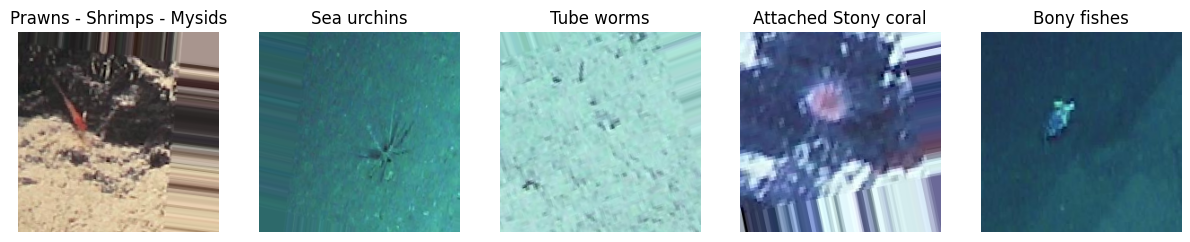

In [11]:
visualize_images(train_generator, num_images=5)

In [12]:
# Print class indices to verify class-to-index mapping
print("Class Indices (Mapping):", train_generator.class_indices)

# Get the total number of samples in train, validation, and test datasets
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")

Class Indices (Mapping): {'Anthomastus Like coral': 0, 'Arborescent Stumpy Grey Branching Erect sponges': 1, 'Arborescent coral': 2, 'Attached Stony coral': 3, 'Bioturbation - Organism tests': 4, 'Bony fishes': 5, 'Colonial Unstalked Ascidian': 6, 'Crab': 7, 'Ctenophores jellies': 8, 'Cup-likes sponges': 9, 'Eels': 10, 'Feather stars': 11, 'Free-living coral': 12, 'General unknown biology': 13, 'Hermit Crab with Shell or Stone': 14, 'Irregular urchins': 15, 'Laminar Erect sponges': 16, 'Octopods': 17, 'Other anemones': 18, 'Prawns - Shrimps - Mysids': 19, 'Quill (Sea pen) coral': 20, 'Sea Cucumber': 21, 'Sea stars': 22, 'Sea urchins': 23, 'Sea whip coral': 24, 'Simple Branching coral': 25, 'Snake stars': 26, 'Squat lobsters': 27, 'Stalked Erect sponges': 28, 'True lobsters': 29, 'Tube anemones': 30, 'Tube worms': 31, 'Woody debris': 32}
Number of training samples: 2145
Number of validation samples: 121
Number of test samples: 660


In [13]:
# Retrieve a batch of images and labels from the training generator
x_batch, y_batch = next(train_generator)

In [14]:
# Print the shape of the batch
print(f"Shape of a batch of images: {x_batch.shape}")
print(f"Shape of a batch of labels: {y_batch.shape}")

Shape of a batch of images: (32, 224, 224, 3)
Shape of a batch of labels: (32, 33)


In [15]:
# Visualize preprocessed images and their corresponding labels
def show_preprocessed_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    class_names = list(train_generator.class_indices.keys())  # Class names
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])  # Image is already rescaled
        label = class_names[np.argmax(labels[i])]
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

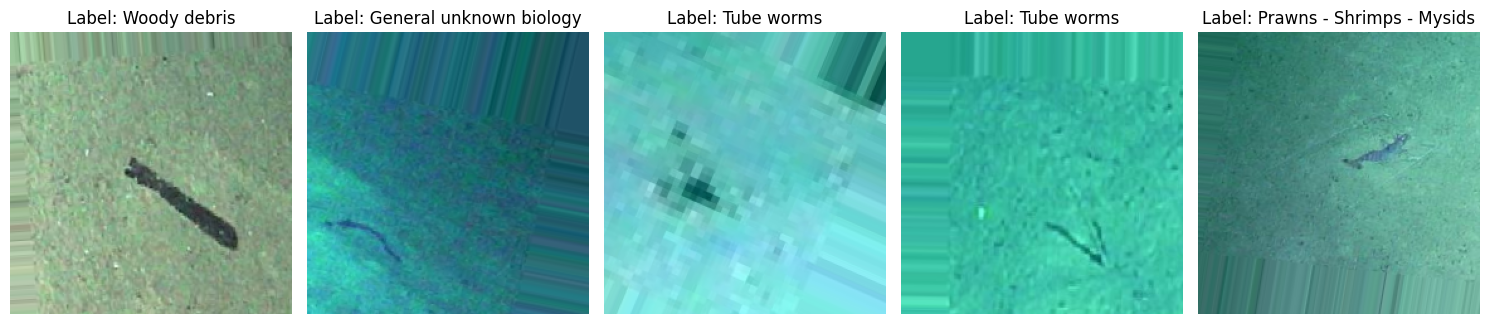

In [16]:
# Show the first batch of preprocessed images
show_preprocessed_images(x_batch, y_batch, num_images=5)